In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 1

# 多項式回帰

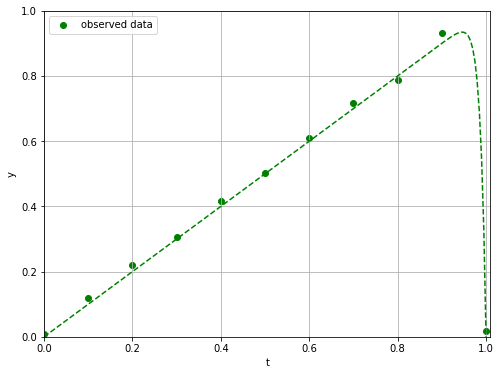

In [2]:
poly_dim = 80

w = np.concatenate(([-1], [0]*(poly_dim-2), [1, 0]))
f = np.poly1d(w)
t = np.linspace(0, 1, 200)
x = np.arange(0, 1.1, step=0.1)
y = f(x) + np.random.normal(loc=0.01, scale=0.01, size=len(x))

def format_plot():
    plt.xlabel('t')
    plt.ylabel('y')
    plt.xlim((0,1.01))
    plt.ylim((0,1))
    plt.grid()
    plt.legend()

plt.figure(figsize=(8,6))
plt.plot(t, f(t), linestyle='dashed', color='green')
plt.scatter(x, y, color='green', marker='o', label="observed data")
format_plot()

In [5]:
# 前準備
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_preprocess = PolynomialFeatures(poly_dim, include_bias=False)

# models
linear = LinearRegression()
lasso = Lasso(alpha=0.002, max_iter=500000, tol=0.000001)

def fit_and_predict(predictor):
    model = make_pipeline(poly_preprocess, predictor)
    model.fit(x.reshape(-1, 1), y)
    y_predicted = model.predict(x.reshape(-1, 1))
    t_predicted = model.predict(t.reshape(-1, 1))
    return y_predicted, t_predicted

## Linear Regression

CPU times: user 80 ms, sys: 40 ms, total: 120 ms
Wall time: 81.8 ms


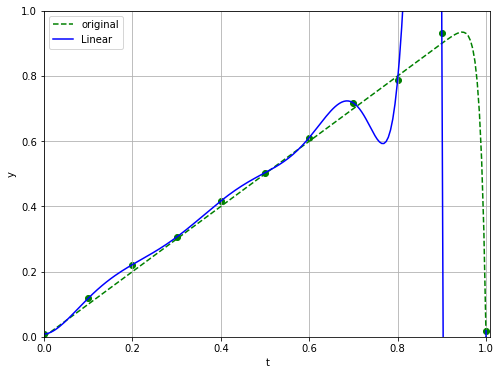

In [8]:
%%time

y_predicted, t_predicted = fit_and_predict(linear)

plt.figure(figsize=(8,6))
plt.plot(t, f(t), linestyle='dashed', color='green', label='original')
plt.plot(t, t_predicted, color='blue', label='Linear')
plt.scatter(x, y_predicted, color='green', marker='o')

format_plot()

Text(0.5,1,'Linear')

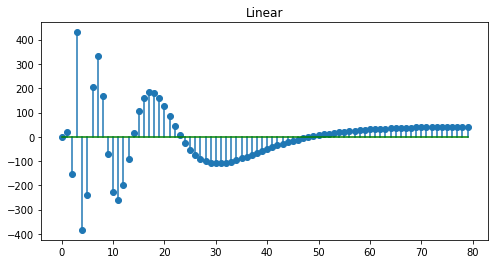

In [9]:
coef = linear.coef_
idx, = coef.nonzero()
plt.figure(figsize=(8,4))
plt.stem(idx, coef[idx], basefmt='g-')
plt.title('Linear')

## Lasso

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.42 s


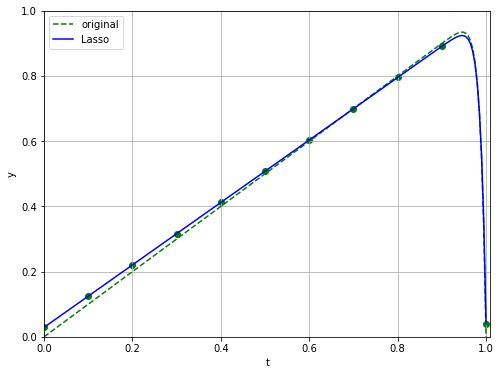

In [11]:
%%time

y_predicted, t_predicted = fit_and_predict(lasso)

plt.figure(figsize=(8,6))
plt.plot(t, f(t), linestyle='dashed', color='green', label='original')
plt.plot(t, t_predicted, color='blue', label='Lasso')
plt.scatter(x, y_predicted, color='green', marker='o')

format_plot()

Text(0.5,1,'Lasso')

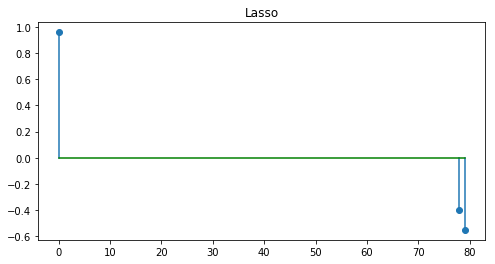

In [13]:
coef = lasso.coef_
idx, = coef.nonzero()
plt.figure(figsize=(8,4))
plt.stem(idx, coef[idx], basefmt='g-')
plt.title('Lasso')

# 辞書学習

In [63]:
patch_size = (8, 8)

n_basis = 64
n_iter = 1000

(768, 1024)


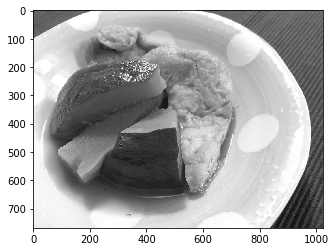

In [19]:
import cv2

img = cv2.imread('data/recipe.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img, cmap='gray')

## シンプルな辞書学習とその結果

In [64]:
%%time

# パッチの切り出し
from spmimage.feature_extraction.image import extract_simple_patches_2d, reconstruct_from_simple_patches_2d
patches = extract_simple_patches_2d(img, patch_size)
print(patches.shape)

(12288, 8, 8)
CPU times: user 40 ms, sys: 10 ms, total: 50 ms
Wall time: 50.5 ms


In [65]:
%%time

from sklearn.decomposition import MiniBatchDictionaryLearning

# パッチの前処理
patches = patches.reshape(patches.shape[0], -1).astype(np.float64)
intercept = np.mean(patches, axis=0)
patches -= intercept
patches /= np.std(patches, axis=0)

# 辞書学習
model = MiniBatchDictionaryLearning(n_components=n_basis, alpha=1, n_iter=n_iter, n_jobs=1)
model.fit(patches)

CPU times: user 6.73 s, sys: 330 ms, total: 7.06 s
Wall time: 6.62 s


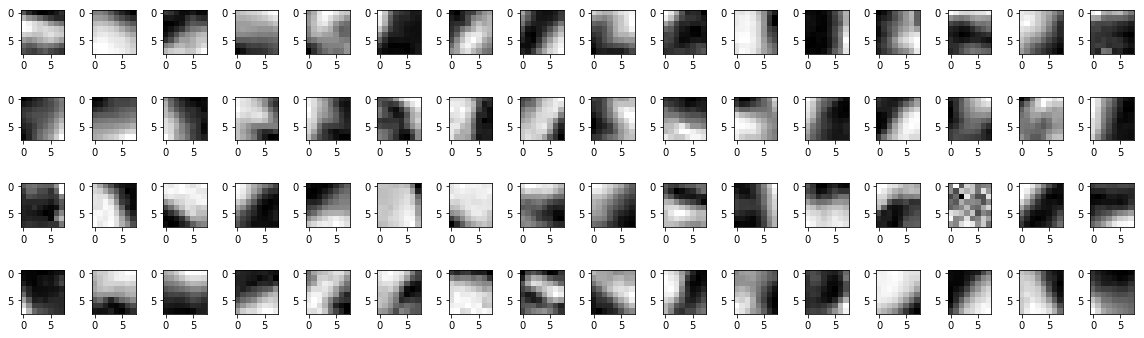

In [79]:
# 辞書の表示

n_cols = 16
n_rows = (n_basis // n_cols) + 1

plt.figure(figsize=(16, 6))

for i, base in enumerate(model.components_):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(base.reshape(patch_size), 'gray', interpolation='nearest')

plt.tight_layout()

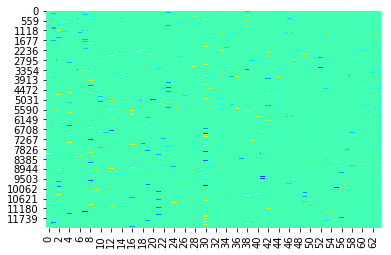

In [80]:
# 元データの係数行列

code = model.transform(patches)
sns.heatmap(code, cmap='jet', cbar=False)

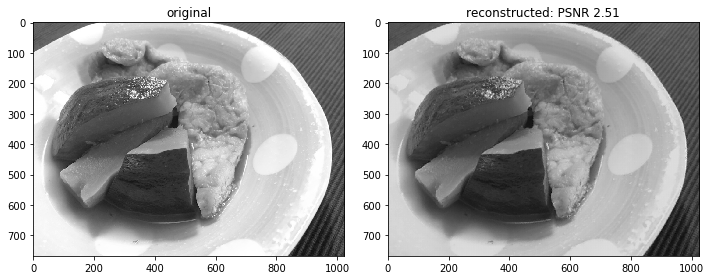

In [82]:
# 再構成をかける

from skimage.measure import compare_psnr

reconstructed_patches = np.dot(code, model.components_)
reconstructed_patches = reconstructed_patches.reshape(len(patches), *patch_size)

reconstructed = reconstruct_from_simple_patches_2d(reconstructed_patches, img.shape)
recipe_psnr = compare_psnr(img, reconstructed.astype(np.uint8))

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.title(f'original')

plt.subplot(1,2,2)
plt.imshow(reconstructed, 'gray')
plt.title(f'reconstructed: PSNR {recipe_psnr:.02f}')

plt.tight_layout()

## 欠損値の補完

In [46]:
from skimage import io, data

from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition.dict_learning import sparse_encode

from spmimage.decomposition import KSVD

In [42]:
# 指定の割合で欠損を生成させる
def make_deficit_image(img, ratio):
    mask = (np.random.rand(img.shape[0], img.shape[1]) > ratio)
    return img * mask, mask

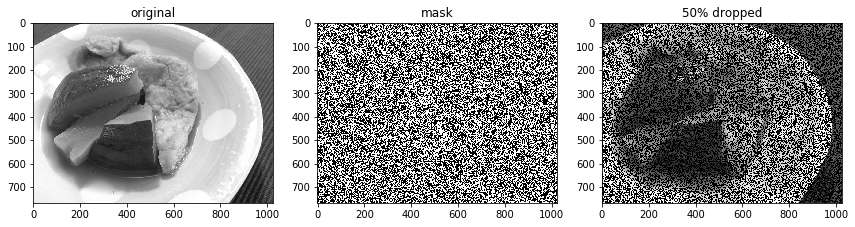

In [45]:
# prepare images for further testing
drop_ratio = 0.5

deficit_img, mask = make_deficit_image(img, drop_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('original')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(1, 3, 3)
plt.imshow(deficit_img, cmap='gray')
plt.title('{0:.0f}% dropped'.format(drop_ratio * 100))

plt.tight_layout()

In [47]:
def extract_and_flatten(img):
    patches = extract_patches_2d(img, patch_size)
    X = []
    for p in patches:
        X.append(p.flatten())
    return np.array(X)    

def sparse_encode_with_mask(img, H, k0, mask):
    Y = extract_and_flatten(img)
    M = extract_and_flatten(mask)
        
    W = np.zeros((Y.shape[0], H.shape[0]))
    for idx in range(Y.shape[0]):
        W[idx, :] = sparse_encode(
            Y[idx, :][M[idx, :] == 1].reshape(1, -1),
            H[:, M[idx, :] == 1],
            algorithm='omp', n_nonzero_coefs=k0
        )
    return W

def reconstruct_image(img, W, H):
    recon_patches = (np.dot(W, H)).reshape((-1, *patch_size))
    recon_img = reconstruct_from_patches_2d(recon_patches, img.shape)
    return recon_img

In [51]:
%%time
X = extract_and_flatten(deficit_img)
model = KSVD(n_components=n_basis, k0=10, max_iter=1000, missing_value=0)
model.fit(X)

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/dict_learning.py:160: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


KeyboardInterrupt: 